In [1]:
import duckdb
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.feature_selection import mutual_info_regression


# run utils.db_setup to set up duckdb database
conn = duckdb.connect('hm.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

# graphs too large for interactivity
pio.renderers.default = 'svg'

## Schema
![](hm_schema.png)

## Tasks

### `rel-hm-user-churn`

Task is to predict 1-week churn for customers.

Binary Classification

Metric: ROCAUC

In [25]:
%%sql train_df <<
from user_churn_train

In [26]:
train_df.head()

,timestamp,customer_id,churn
0,2020-08-31,1331209,1
1,2020-08-31,1331240,1
2,2020-08-31,1331262,1
3,2020-08-31,1331282,0
4,2020-08-31,1331342,1


In [27]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.customer_id.nunique():,} users.')
print()
print('Label Distribution:')
print(train_df.churn.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
months = train_df.timestamp.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='customer_id', keep='last')
    .groupby(months).customer_id.nunique() / train_df.customer_id.nunique()
)

TRAIN

3,871,410 samples over 987,342 users.

Label Distribution:
churn
1    0.818918
0    0.181082
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2019-09    0.077468
2019-10    0.077687
2019-11    0.070152
2019-12    0.112875
2020-01    0.068095
2020-02    0.070049
2020-03    0.080166
2020-04    0.068805
2020-05    0.069357
2020-06    0.123342
2020-07    0.083125
2020-08    0.098878
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2019-09    0.234032
2019-10    0.143322
2019-11    0.092578
2019-12    0.120716
2020-01    0.053358
2020-02    0.050162
2020-03    0.063333
2020-04    0.061639
2020-05    0.044927
2020-06    0.062457
2020-07    0.034447
2020-08    0.039029
Name: customer_id, dtype: float64


In [28]:
%%sql val_df <<
from user_churn_val;

In [29]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.customer_id.nunique():,} users.')
print()
print('Label Distribution:')
print(val_df.churn.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
months = val_df.timestamp.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print(f'Customers in val seen in train: {len(set(val_df.customer_id) & set(train_df.customer_id)):,}')
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='customer_id', keep='last')
    .groupby(months).customer_id.nunique() / val_df.customer_id.nunique()
)

VAL

76,556 samples over 76,556 users.

Label Distribution:
churn
1    0.812804
0    0.187196
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2020-09    1.0
Name: proportion, dtype: float64

Customers in val seen in train: 68,615

Temporal dist of users (first appearance):
timestamp
2020-09    1.0
Name: customer_id, dtype: float64


### `rel-hm-item-sales`

Task is to predict the total sales for an article (the sum of prices of the associated transactions) in the next week.

Regression

Metric: MAE

In [20]:
%%sql train_df <<
from item_sales_train

In [21]:
train_df.head()

,timestamp,article_id,sales
0,2020-08-31,102400,1.357508
1,2020-08-31,102401,0.000000
2,2020-08-31,102403,1.698186
3,2020-08-31,102405,0.013542
4,2020-08-31,102406,0.039271


In [22]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.article_id.nunique():,} products.')
print()
print('Temporal dist of samples:')
months = train_df.timestamp.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print('Temporal dist of articles (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='article_id', keep='last')
    .groupby(months).article_id.nunique() / train_df.article_id.nunique()
)
print()
print('Label Distribution:')
mean = train_df.sales.mean()
std = train_df.sales.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(train_df.sales == 0).mean():.1%}')
print(f'Quantiles: \n{train_df.sales.quantile(np.arange(0, 1.1, 0.1))}')

TRAIN

5,488,184 samples over 105,542 products.

Temporal dist of samples:
timestamp
2019-09    0.076923
2019-10    0.076923
2019-11    0.076923
2019-12    0.096154
2020-01    0.076923
2020-02    0.076923
2020-03    0.096154
2020-04    0.076923
2020-05    0.076923
2020-06    0.096154
2020-07    0.076923
2020-08    0.096154
Name: proportion, dtype: float64

Temporal dist of articles (first appearance):
timestamp
2019-09    0.732145
2019-10    0.046266
2019-11    0.042012
2019-12    0.042419
2020-01    0.028851
2020-02    0.025014
2020-03    0.023176
2020-04    0.017794
2020-05    0.014193
2020-06    0.013265
2020-07    0.007618
2020-08    0.007248
Name: article_id, dtype: float64

Label Distribution:
Mean (std): 0.1 ± 0.5
Prop zeros: 81.4%
Quantiles: 
0.0     0.000000
0.1     0.000000
0.2     0.000000
0.3     0.000000
0.4     0.000000
0.5     0.000000
0.6     0.000000
0.7     0.000000
0.8     0.000000
0.9     0.074983
1.0    87.162593
Name: sales, dtype: float64


In [121]:
%%sql val_df <<
from item_sales_val

In [24]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.article_id.nunique():,} products.')
print()
print('Temporal dist of samples:')
months = val_df.timestamp.dt.strftime('%Y-%m')
print(months.value_counts(normalize=True).sort_index())
print()
print('Temporal dist of articles (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='article_id', keep='last')
    .groupby(months).article_id.nunique() / val_df.article_id.nunique()
)
print()
print(f'Articles in val seen in train: {len(set(val_df.article_id) & set(train_df.article_id)):,}')
print()
print('Label Distribution:')
mean = val_df.sales.mean()
std = val_df.sales.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(val_df.sales == 0).mean():.1%}')
print(f'Quantiles: \n{val_df.sales.quantile(np.arange(0, 1.1, 0.1))}')

VAL

105,542 samples over 105,542 products.

Temporal dist of samples:
timestamp
2020-09    1.0
Name: proportion, dtype: float64

Temporal dist of articles (first appearance):
timestamp
2020-09    1.0
Name: article_id, dtype: float64

Articles in val seen in train: 105,542

Label Distribution:
Mean (std): 0.1 ± 0.7
Prop zeros: 82.3%
Quantiles: 
0.0     0.000000
0.1     0.000000
0.2     0.000000
0.3     0.000000
0.4     0.000000
0.5     0.000000
0.6     0.000000
0.7     0.000000
0.8     0.000000
0.9     0.060983
1.0    40.364915
Name: sales, dtype: float64


## Article

In [122]:
%%sql article <<
from article

In [123]:
article.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,1,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,2,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,3,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,4,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


### Categoricals


In [124]:
def analyze_cat(df, col):
    print(f'{col.upper()}\n')
    print(f'Unique values: {df[col].nunique()}')
    print()
    print(f'Value counts:\n{df[col].value_counts(normalize=True, dropna=False)}')
    print()

In [87]:
analyze_cat(article, 'section_name')

SECTION_NAME

Unique values: 56

Value counts:
section_name
Womens Everyday Collection        0.069119
Divided Collection                0.067499
Baby Essentials & Complements     0.046730
Kids Girl                         0.042343
Young Girl                        0.036943
Womens Lingerie                   0.034091
Girls Underwear & Basics          0.033067
Womens Tailoring                  0.031987
Kids Boy                          0.031532
Womens Small accessories          0.030983
Womens Casual                     0.025819
Kids Outerwear                    0.025251
Womens Trend                      0.024843
Divided Projects                  0.022399
Young Boy                         0.022285
H&M+                              0.022143
Men Underwear                     0.022001
Mama                              0.021470
Kids & Baby Shoes                 0.020295
Boys Underwear & Basics           0.019272
Womens Shoes                      0.019196
Ladies H&M Sport                  0.0

In [88]:
analyze_cat(article, 'garment_group_name')

GARMENT_GROUP_NAME

Unique values: 21

Value counts:
garment_group_name
Jersey Fancy                     0.203189
Accessories                      0.109141
Jersey Basic                     0.076993
Knitwear                         0.070967
Under-, Nightwear                0.070503
Trousers                         0.063738
Blouses                          0.055314
Shoes                            0.048748
Dresses Ladies                   0.046181
Outdoor                          0.042647
Unknown                          0.036696
Trousers Denim                   0.029372
Swimwear                         0.026407
Socks and Tights                 0.021527
Shirts                           0.020049
Woven/Jersey/Knitted mix Baby    0.018618
Shorts                           0.014771
Dresses/Skirts girls             0.014601
Skirts                           0.011882
Special Offers                   0.010053
Dressed                          0.008603
Name: proportion, dtype: float64



In [89]:
analyze_cat(article, 'product_group_name')

PRODUCT_GROUP_NAME

Unique values: 19

Value counts:
product_group_name
Garment Upper body       0.404967
Garment Lower body       0.187717
Garment Full body        0.125940
Accessories              0.105721
Underwear                0.052017
Shoes                    0.050056
Swimwear                 0.029628
Socks & Tights           0.023138
Nightwear                0.017993
Unknown                  0.001146
Underwear/nightwear      0.000512
Cosmetic                 0.000464
Bags                     0.000237
Items                    0.000161
Furniture                0.000123
Garment and Shoe care    0.000085
Stationery               0.000047
Interior textile         0.000028
Fun                      0.000019
Name: proportion, dtype: float64



In [90]:
analyze_cat(article, 'department_name')

DEPARTMENT_NAME

Unique values: 250

Value counts:
department_name
Jersey                             0.043622
Knitwear                           0.033191
Trouser                            0.025156
Blouse                             0.022380
Dress                              0.019774
                                     ...   
Woven bottoms inactive from S.7    0.000009
Jersey inactive from S.6           0.000009
EQ Divided Blue                    0.000009
Accessories Other                  0.000009
Kids Boy License                   0.000009
Name: proportion, Length: 250, dtype: float64



In [91]:
analyze_cat(article, 'index_group_name')

INDEX_GROUP_NAME

Unique values: 5

Value counts:
index_group_name
Ladieswear       0.376504
Baby/Children    0.328883
Divided          0.143535
Menswear         0.118938
Sport            0.032139
Name: proportion, dtype: float64



In [92]:
analyze_cat(article, 'index_name')

INDEX_NAME

Unique values: 10

Value counts:
index_name
Ladieswear                        0.246357
Divided                           0.143535
Menswear                          0.118938
Children Sizes 92-140             0.113765
Children Sizes 134-170            0.087302
Baby Sizes 50-98                  0.084090
Ladies Accessories                0.065955
Lingeries/Tights                  0.064192
Children Accessories, Swimwear    0.043727
Sport                             0.032139
Name: proportion, dtype: float64



In [93]:
analyze_cat(article, 'perceived_colour_master_name')

PERCEIVED_COLOUR_MASTER_NAME

Unique values: 20

Value counts:
perceived_colour_master_name
Black              0.213991
Blue               0.174992
White              0.120000
Pink               0.089092
Grey               0.084554
Red                0.055693
Beige              0.053600
Green              0.033409
Khaki green        0.030140
Yellow             0.029571
Orange             0.025904
Brown              0.021499
Metal              0.020655
Turquoise          0.017330
Mole               0.011588
Lilac Purple       0.010422
Unknown            0.006490
undefined          0.000995
Yellowish Green    0.000047
Bluish Green       0.000028
Name: proportion, dtype: float64



In [94]:
analyze_cat(article, 'perceived_colour_value_name')

PERCEIVED_COLOUR_VALUE_NAME

Unique values: 8

Value counts:
perceived_colour_value_name
Dark            0.404635
Dusty Light     0.209888
Light           0.149125
Medium Dusty    0.119668
Bright          0.061312
Medium          0.054111
Undefined       0.000995
Unknown         0.000265
Name: proportion, dtype: float64



In [95]:
analyze_cat(article, 'colour_group_name')

COLOUR_GROUP_NAME

Unique values: 50

Value counts:
colour_group_name
Black              0.214796
Dark Blue          0.115319
White              0.090410
Light Pink         0.055059
Grey               0.042514
Light Beige        0.031798
Blue               0.031343
Red                0.028955
Light Blue         0.028538
Greenish Khaki     0.026217
Dark Grey          0.025876
Off White          0.025829
Beige              0.025696
Dark Red           0.022171
Dark Green         0.019954
Light Grey         0.019945
Pink               0.019547
Yellow             0.015586
Light Orange       0.014402
Yellowish Brown    0.013938
Gold               0.013047
Dark Beige         0.010271
Light Turquoise    0.009731
Light Yellow       0.009323
Dark Orange        0.008395
Dark Pink          0.007750
Green              0.007722
Orange             0.007381
Other Pink         0.007106
Silver             0.006718
Light Green        0.006452
Dark Yellow        0.005439
Light Purple       0.005240
Dark T

In [96]:
analyze_cat(article, 'graphical_appearance_name')

GRAPHICAL_APPEARANCE_NAME

Unique values: 30

Value counts:
graphical_appearance_name
Solid                  0.471348
All over pattern       0.162637
Melange                0.056262
Stripe                 0.047280
Denim                  0.045877
Front print            0.030462
Placement print        0.029353
Check                  0.020636
Colour blocking        0.017339
Lace                   0.014336
Other structure        0.014231
Application/3D         0.012706
Embroidery             0.011038
Mixed solid/pattern    0.010726
Glittering/Metallic    0.009077
Jacquard               0.007864
Sequin                 0.007637
Dot                    0.006452
Treatment              0.005552
Other pattern          0.004880
Contrast               0.003563
Metallic               0.003278
Chambray               0.003051
Slub                   0.001450
Transparent            0.000815
Mesh                   0.000815
Neps                   0.000625
Unknown                0.000493
Argyle            

In [97]:
analyze_cat(article, 'product_type_name')

PRODUCT_TYPE_NAME

Unique values: 131

Value counts:
product_type_name
Trousers         0.105825
Dress            0.098179
Sweater          0.088136
T-shirt          0.074890
Top              0.039368
                   ...   
Keychain         0.000009
Headband         0.000009
Cushion          0.000009
Blanket          0.000009
Clothing mist    0.000009
Name: proportion, Length: 131, dtype: float64



In [98]:
analyze_cat(article, 'product_code')

PRODUCT_CODE

Unique values: 47224

Value counts:
product_code
783707    0.000711
684021    0.000663
699923    0.000493
699755    0.000464
685604    0.000436
            ...   
761368    0.000009
761366    0.000009
761360    0.000009
761350    0.000009
959461    0.000009
Name: proportion, Length: 47224, dtype: float64



In [127]:
joined = val_df.join(article, on='article_id', rsuffix='_')
mi = mutual_info_regression(
    joined[
        ['product_type_no', 'perceived_colour_master_id', 'graphical_appearance_no',
         'index_group_no', 'department_no', 'section_no', 'garment_group_no', 'colour_group_code']
    ].values,
    joined['sales'].values
)

In [128]:
pd.Series({
    col: mi 
    for col, mi in zip(
        ['product_type_no', 'perceived_colour_master_id', 'graphical_appearance_no',
         'index_group_no', 'department_no', 'section_no', 'garment_group_no', 'colour_group_code'],
        mi
    )
}).sort_values(ascending=False)

department_no                 0.082520
section_no                    0.070054
index_group_no                0.040517
product_type_no               0.039509
garment_group_no              0.035272
perceived_colour_master_id    0.018759
colour_group_code             0.017110
graphical_appearance_no       0.012033
dtype: float64

Notes:
- article table pretty much categoricals only
- Many columns overlap
- Probably going for `department_no`, `section_no`, `perceived_colour_master_id` as the others are coarser categorizations of
the same things.

In [59]:
article.detail_desc.head()

0              Jersey top with narrow shoulder straps.
1              Jersey top with narrow shoulder straps.
2              Jersey top with narrow shoulder straps.
3    Microfibre T-shirt bra with underwired, moulde...
4    Microfibre T-shirt bra with underwired, moulde...
Name: detail_desc, dtype: object

In [60]:
article.detail_desc.str.len().describe()

count    105126.000000
mean        142.161901
std          68.094916
min          11.000000
25%          94.000000
50%         132.000000
75%         178.000000
max         764.000000
Name: detail_desc, dtype: float64

## Customer

In [77]:
%%sql customer <<
from customer

In [78]:
customer.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,1,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,3,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,4,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [81]:
customer.FN.value_counts(normalize=True, dropna=False)

FN
NaN    0.652378
1.0    0.347622
Name: proportion, dtype: float64

In [83]:
customer.Active.value_counts(normalize=True, dropna=False)

Active
NaN    0.661508
1.0    0.338492
Name: proportion, dtype: float64

In [84]:
customer.club_member_status.value_counts(normalize=True, dropna=False)

club_member_status
ACTIVE        0.927485
PRE-CREATE    0.067756
None          0.004418
LEFT CLUB     0.000340
Name: proportion, dtype: float64

In [99]:
customer.fashion_news_frequency.value_counts(normalize=True, dropna=False)

fashion_news_frequency
NONE         0.639740
Regularly    0.347976
None         0.011669
Monthly      0.000614
None         0.000001
Name: proportion, dtype: float64

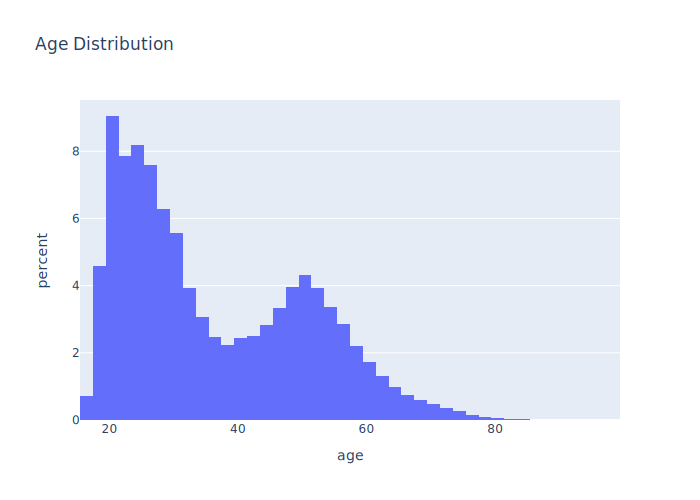

In [103]:
px.histogram(customer, x='age', nbins=60, title='Age Distribution', histnorm='percent')

In [105]:
customer.postal_code.nunique()

352899

## Transactions

In [19]:
%%sql transactions <<
from transactions

In [20]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,2,40179,0.050831,2
1,2018-09-20,2,10520,0.030492,2
2,2018-09-20,7,6387,0.015237,2
3,2018-09-20,7,46304,0.016932,2
4,2018-09-20,7,46305,0.016932,2


In [109]:
print(f'{len(transactions):,} transactions')

31,521,960 transactions


In [124]:
by_article = transactions.groupby('article_id').price.sum()

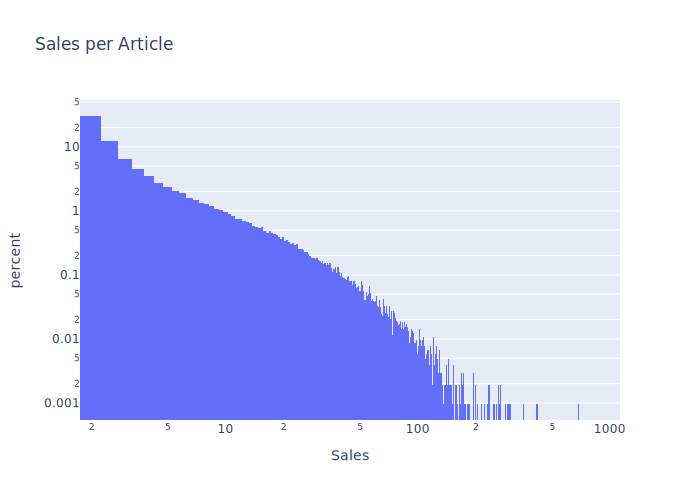

In [126]:
px.histogram(
    x=(by_article + 1), title='Sales per Article', histnorm='percent', log_y=True,
    log_x=True, labels={'x': 'Sales'}
)

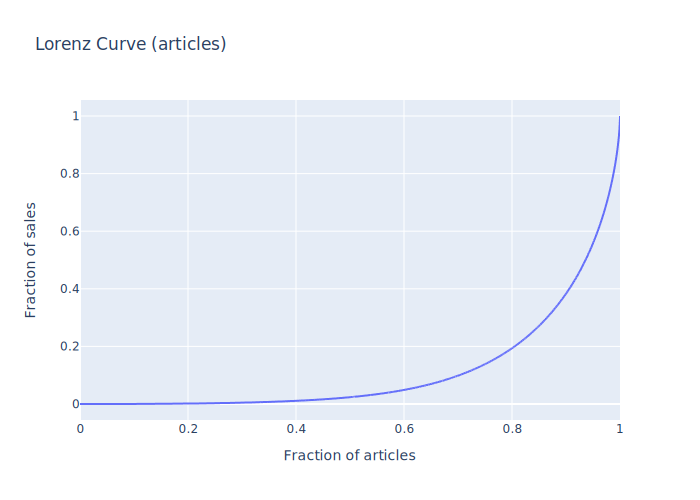

In [127]:
cum_sales = by_article.sort_values().cumsum() / by_article.sum()
px.line(
    x=np.arange(len(cum_sales)) / len(cum_sales), y=cum_sales, title='Lorenz Curve (articles)',
    labels={'x': 'Fraction of articles', 'y': 'Fraction of sales'}
)

^ Pareto principle

In [128]:
by_customer = transactions.groupby('customer_id').price.sum()

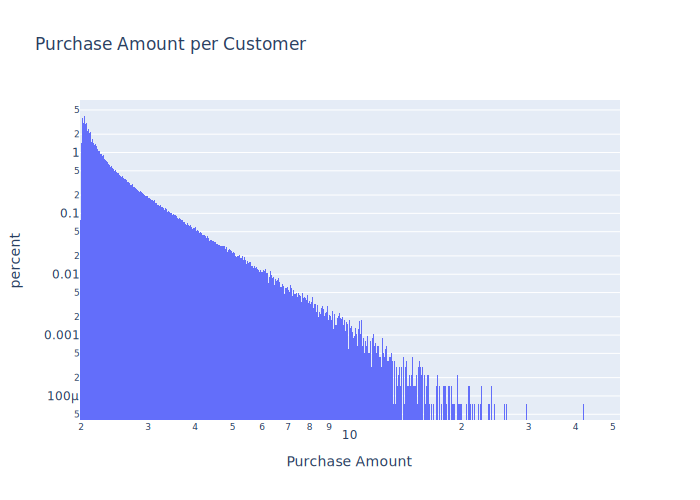

In [129]:
px.histogram(
    x=(by_customer + 1), title='Purchase Amount per Customer', histnorm='percent', log_y=True,
    log_x=True, labels={'x': 'Purchase Amount'}
)

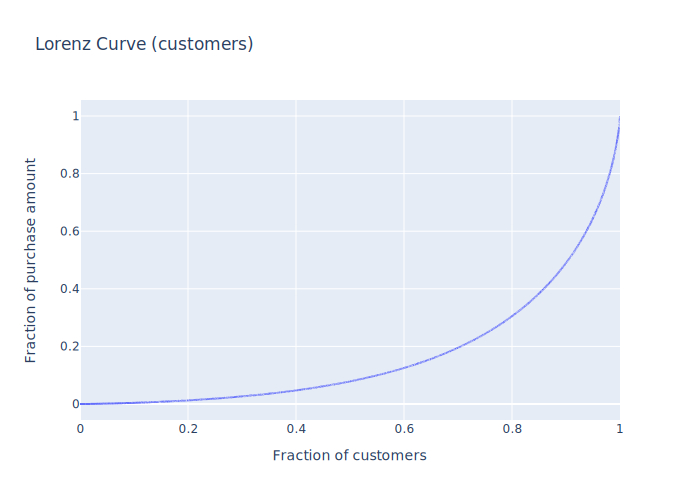

In [130]:
cum_sales = by_customer.sort_values().cumsum() / by_article.sum()
px.line(
    x=np.arange(len(cum_sales)) / len(cum_sales), y=cum_sales, title='Lorenz Curve (customers)',
    labels={'x': 'Fraction of customers', 'y': 'Fraction of purchase amount'}
)

In [131]:
transactions.sales_channel_id.value_counts(normalize=True, dropna=False)

sales_channel_id
2    0.704108
1    0.295892
Name: proportion, dtype: float64

In [132]:
transactions.groupby('sales_channel_id').price.agg(['mean', 'size', 'sum'])

,mean,size,sum
sales_channel_id,,,
1,0.022893,9327082,213526.086712
2,0.029825,22194878,661956.090000


In [25]:
%%sql txns_by_month <<
select
    strftime('%Y-%m', t_dat) as month,
    count(*) as num_sales,
    sum(price) as sold_amount
from transactions
group by month

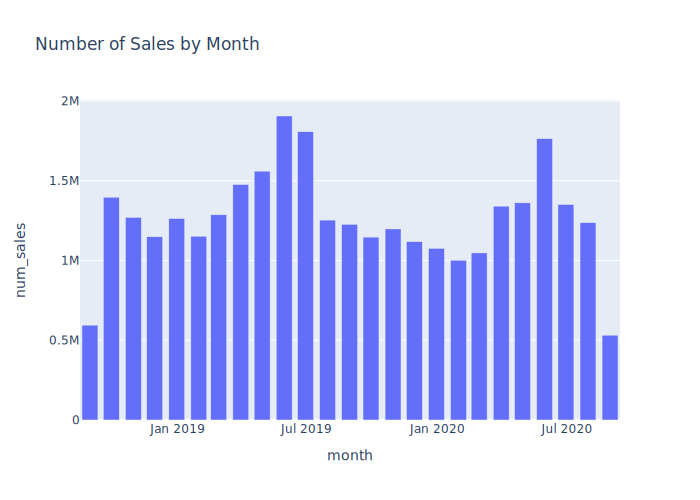

In [27]:
px.bar(txns_by_month, x='month', y='num_sales', title='Number of Sales by Month')

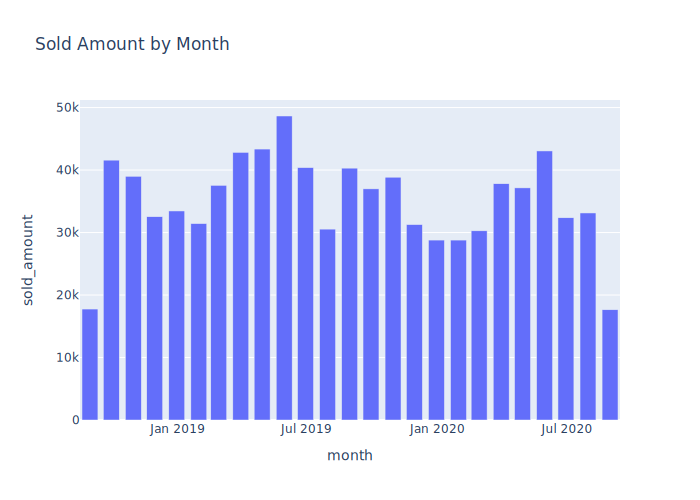

In [28]:
px.bar(txns_by_month, x='month', y='sold_amount', title='Sold Amount by Month')

In [111]:
%%sql variability <<
with ids as (
    select article_id from article using sample 100
)
select
    ids.article_id,
    date_part('week', t.t_dat) as week,
    count(*) as num_sales,
    sum(t.price) as sold_amount,
    avg(t.price) as avg_price
from ids
left join transactions as t
    on ids.article_id = t.article_id
where
    t.t_dat between '2019-01-01'::timestamp and '2019-12-31'::timestamp
group by ids.article_id, week
order by ids.article_id, week asc

In [112]:
first_weeks = variability.groupby('article_id').week.first()

In [113]:
valid = first_weeks[first_weeks == 1].index

In [114]:
valid

Index([ 2264,  7654,  8006,  9413,  9483, 11351, 14235, 15056, 15678, 17935,
       25976, 32066, 33538, 36257, 37688, 38601, 39256, 41409, 41593, 43373,
       46284, 46995, 47115, 47578, 47860, 49177, 53178, 54585, 55762, 57699,
       57879, 58674, 71130, 76223, 76431, 87501, 93413],
      dtype='int64', name='article_id')

In [115]:
variability = variability[variability.article_id.isin(valid)]
first_weeks = first_weeks[first_weeks == 1]
variability = variability.set_index(['article_id', 'week'])
first_week_values = variability.loc[list(zip(first_weeks.index, first_weeks))]

In [116]:
first_week_values.droplevel('week', 0)

,num_sales,sold_amount,avg_price
article_id,,,
2264,14,0.232085,0.016577
7654,3,0.042322,0.014107
8006,2,0.054203,0.027102
9413,7,0.237169,0.033881
9483,2,0.112678,0.056339
11351,1,0.010153,0.010153
14235,1,0.006763,0.006763
15056,1,0.003373,0.003373
15678,27,0.488864,0.018106


In [117]:
normed_var = np.log2(variability / first_week_values.droplevel('week', 0))

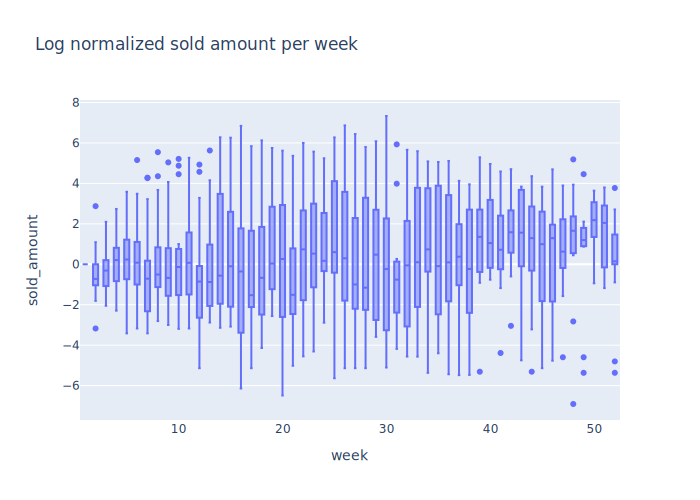

In [118]:
px.box(
    normed_var.reset_index(), x='week', y='sold_amount',
    title='Log normalized sold amount per week',
)

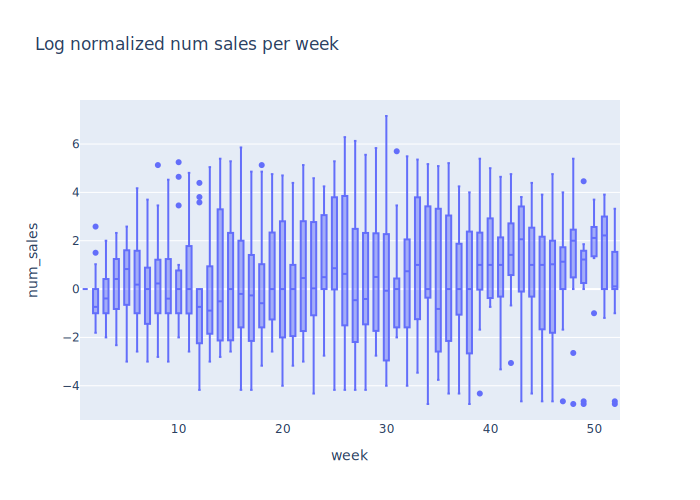

In [119]:
px.box(
    normed_var.reset_index(), x='week', y='num_sales',
    title='Log normalized num sales per week',
)

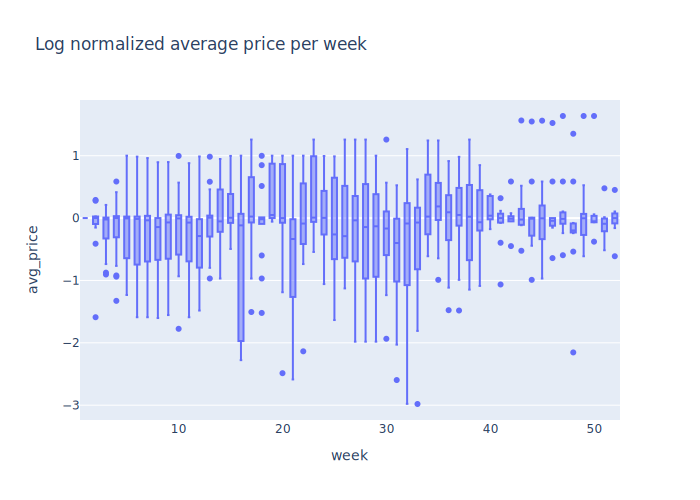

In [120]:
px.box(
    normed_var.reset_index(), x='week', y='avg_price',
    title='Log normalized average price per week',
)

Notes:
- Seasonality: sales peak in summer months
- Very high variability in number/amount of sales week-over-week
- Prices are more stable but do exhibit some variability downwards (ie discounts)

In [129]:
conn.close()